In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
from scipy.spatial import distance
import random
from numpy.matlib import repmat
from scipy.linalg import null_space
from tqdm import tqdm

# Fundamental matrix from scratch

In [2]:
def SIFT_features(img,k): #to obtain keypoints and descriptors of the image passed
    sift=cv2.xfeatures2d.SIFT_create(nfeatures=k) 
    kp,des=sift.detectAndCompute(img,None) #size of sift descriptor=128xno of key-points detected
    return(kp,des)

In [3]:
def feature_matching(kp1,kp2,des1,des2): 
    dist=[] 
    pairs=[]
    match=[] #(contains tuples(i,j), ith keypoint in image 1 matches with jth keypoint in image 2)
    
    for i in range(des1.shape[0]):#loop over all keypoints of image 1
        temp=[]
        for j in range(des2.shape[0]): #loop over all keypoints of image 2
            d=distance.euclidean(des1[i], des2[j])
            temp.append(d)
  
        match_index=temp.index(min(temp))
        match.append((i,match_index))
        pairs.append([kp1[i].pt[0],kp1[i].pt[1],kp2[match_index].pt[0],kp2[match_index].pt[1]])
        
        dist.append(min(temp))
    
    pairs=np.array(pairs)
    dist=np.array(dist)
    #print(dist)
    return(pairs)

In [4]:
#taken as it is from assignment 3
def normalize_points(pt_correspondences):
    set1 = pt_correspondences[:,0:2]
    set2 = pt_correspondences[:,2:4]
    centroid1 = np.sum(set1, axis = 0)/set1.shape[0]
    centroid2 = np.sum(set2, axis = 0)/set2.shape[0]
    diff1 = set1 - centroid1
    diff2 = set2 - centroid2
    avg_dist1 = np.sum(np.sqrt(np.square(diff1[:,0])+np.square(diff1[:,1])) ,axis = 0)/set1.shape[0]
    avg_dist2 = np.sum(np.sqrt(np.square(diff2[:,0])+np.square(diff2[:,1])) ,axis = 0)/set2.shape[0]
    scale1 = np.sqrt(2)/avg_dist1
    scale2 = np.sqrt(2)/avg_dist2
    T1 = np.diag([scale1,scale1,1])*np.array([[1.,0.,-centroid1[0]],[0.,1.,-centroid1[1]],[0.,0.,1]])
    T2 = np.diag([scale2,scale2,1])*np.array([[1.,0.,-centroid2[0]],[0.,1.,-centroid2[1]],[0.,0.,1]])
    newpts1 = np.zeros((set1.shape[0],3),dtype='float64')
    newpts2 = np.zeros((set2.shape[0],3),dtype='float64')
    newpts1[:,0:2] = set1
    newpts2[:,0:2] = set2
    newpts1[:,2] = 1.
    newpts2[:,2] = 1.
    newpts1 = np.dot(newpts1,np.transpose(T1))
    newpts2 = np.dot(newpts2,np.transpose(T2))
    newpts1 = np.divide(newpts1,repmat(newpts1[:,2].reshape(8,1),1,3))
    newpts2 = np.divide(newpts2,repmat(newpts2[:,2].reshape(8,1),1,3))
    normalized_randomEight = np.copy(pt_correspondences)
    normalized_randomEight[:,0:2] = newpts1[:,0:2]
    normalized_randomEight[:,2:4] = newpts2[:,0:2]
    #print('------',normalized_randomEight)
    return normalized_randomEight ,T1 ,T2

In [5]:
# made following the steps in Prof. Shanmuga's notes
def find_fundamental_matrix(pt_correspondences,T1,T2): # Computers a homography from 4ptcorrespondences
    #loop through correspondences and create the A matrix
    A=[]
    for i in pt_correspondences:
        pt1 = np.matrix([i.item(0), i.item(1), 1])
        pt2 = np.matrix([i.item(2), i.item(3), 1])
        x=pt1.item(0)
        y=pt1.item(1)
        u=pt2.item(0)
        v=pt2.item(1)
        a = [x*u,y*u,u,v*x,v*y,v,x,y,1]
        A.append(a)
    matrixA = np.matrix(A)
    #print(matrixA)
    #svd composition
    U, S, V = np.linalg.svd(matrixA,full_matrices=True)
    #reshape the min singular value into a 3 by 3 matrix
    f = V[:,-1]
    F = f.reshape((3,3))
    new_U , new_D, new_V = np.linalg.svd(F,full_matrices=True)
    D = np.diag(new_D)
    D[2,2] = 0
    D = D/ D[0,0]
    F = np.dot(np.dot(new_U,D),np.transpose(new_V))
    F = np.dot(np.dot(np.transpose(T2),F),T1)
    #normalize and now we have h
    return F

In [6]:
def calculate_geometric_distance(pt_correspondence, H): 
#Calculate the geometric distance between estimated points and original points

    pt1 = np.transpose(np.matrix([pt_correspondence[0], pt_correspondence[1], 1]))
    estimate_of_pt2 = np.dot(H, pt1)
    if estimate_of_pt2.item(2)==0:
        return np.inf
    estimate_of_pt2 = (1/estimate_of_pt2.item(2))*estimate_of_pt2

    pt2 = np.transpose(np.matrix([pt_correspondence[2], pt_correspondence[3], 1]))
    error = pt2 - estimate_of_pt2
    return np.linalg.norm(error)

In [7]:
#Runs through ransac algorithm, creating homographies from random pts correspondences
def RANSAC_algo(pts_corr, thresh): 
    maxInliers = []
    finalF = None
    N=3000 #N is the number of Trials
    for i in tqdm(range(N)):
        #print(pts_corr.shape)
        #find 4 random points to calculate a homography
        p1 = pts_corr[random.randrange(0, len(pts_corr))]
        p2 = pts_corr[random.randrange(0, len(pts_corr))]
        
        randomEight = np.vstack((p1, p2))
        
        p3 = pts_corr[random.randrange(0, len(pts_corr))]
        randomEight = np.vstack((randomEight, p3))
        
        p4 = pts_corr[random.randrange(0, len(pts_corr))]
        randomEight = np.vstack((randomEight, p4))
        p5 = pts_corr[random.randrange(0, len(pts_corr))]
        randomEight = np.vstack((randomEight, p5))
        p6 = pts_corr[random.randrange(0, len(pts_corr))]
        randomEight = np.vstack((randomEight, p6))
        p7 = pts_corr[random.randrange(0, len(pts_corr))]
        randomEight = np.vstack((randomEight, p7))
        p8 = pts_corr[random.randrange(0, len(pts_corr))]
        randomEight = np.vstack((randomEight, p8))
        #print('-------------',randomEight)
        try:
            normalized_randomEight, T1, T2 = normalize_points(randomEight)
            F = find_fundamental_matrix(normalized_randomEight,T1, T2)
            inliers = []

            for i in range(len(pts_corr)):
                d = calculate_geometric_distance(pts_corr[i], F)
                #print(d)
                if d < 850:
                    inliers.append(pts_corr[i])

            if len(inliers) > len(maxInliers):
                maxInliers = inliers
                finalF = F
#             if len(maxInliers) > (len(pts_corr)*thresh):
#                 break
        except:
            pass
            
    return finalF



In [8]:
def calculate_and_return_fundamental_matrix(a,b):
    estimation_thresh = 0.50
    kp1,des1=SIFT_features(a,500) #Number of features=10, can change also
    kp2,des2=SIFT_features(b,500)
    
    pts= feature_matching(kp1,kp2,des1,des2)
    
#     #running RANSAC algo
    finalF = RANSAC_algo(pts, estimation_thresh)
    finalF = finalF/finalF[2,2]
    return finalF, pts

# Fundamental matrix using opencv

In [9]:
def calculate_Fundamental_using_opencv(img1,img2):
    sift = cv2.xfeatures2d.SIFT_create() 
    keyPoints1, descriptors1 = sift.detectAndCompute(img1, None) 
    keyPoints2, descriptors2 = sift.detectAndCompute(img2, None) 
    # Create FLANN matcher object 
    FLANN_INDEX_KDTREE = 0
    indexParams = dict(algorithm=FLANN_INDEX_KDTREE, 
                       trees=5) 
    searchParams = dict(checks=50) 
    flann = cv2.FlannBasedMatcher(indexParams, 
                                  searchParams) 
    matches = flann.knnMatch(descriptors1,descriptors2,k=2)
    goodMatches = [] 
    pts1 = [] 
    pts2 = [] 

    for m, n in matches: 

        if m.distance < 0.8 * n.distance: 

            goodMatches.append([m]) 
            try:
                pts1.append(keyPoints1[m.trainIdx].pt) 
                pts2.append(keyPoints2[n.trainIdx].pt) 
            except:
                pass
    pts1 = np.int32(pts1) 

    pts2 = np.int32(pts2) 
    F1, mask = cv2.findFundamentalMat(pts1, 
                                     pts2, 
                                     cv2.FM_LMEDS) 
    return F1

In [10]:
def get_distance(a,b): # a and b are 3*3 sized patches
    return np.sqrt(np.sum(np.square(a-b)))
# epipolar lines in source image
def get_patched_image(img1,img2,F):
    ref_coordinates = np.zeros((3,img1.shape[0]*img1.shape[1]))
    c=0
    for i in range(img1.shape[0]):
        v = 0
        for j in range(img1.shape[1]):
            ref_coordinates[0,c] = i
            ref_coordinates[1,c] = v
            ref_coordinates[2,c] = 1
            c+=1
            v+=1

    epipolar_lines = np.dot(F,ref_coordinates)
    U , D, V = np.linalg.svd(F,full_matrices=True)
    "Right null space = Column of V corresponding to singular value=0"
    e=V[:, -1]
    "LeftNull space = the rows U.T corresponding to singular values equal to zero"
    e_dash=U.T[-1, :]
    
    e_dash_x = (e_dash/e_dash[2])[0]
    e_dash_y = (e_dash/e_dash[2])[1]

    # blank image of dimesions same as source image

    source_copy = np.zeros((img1.shape[0],img1.shape[1]))
    for i in tqdm(range(0,epipolar_lines.shape[1])):
        current_patch = img1[int(ref_coordinates[0,i])-1:int(ref_coordinates[0,i])+2,int(ref_coordinates[1,i])-1:int(ref_coordinates[1,i])+2]
        if current_patch.shape == (3,3):
            line = epipolar_lines[:,i]
            step = np.array([line[0],line[1]])/np.min(np.abs([line[0],line[1]]))
            step= np.reshape(step,(2,))
            pointer = np.array([e_dash_x,e_dash_y])
            #print(ref_coordinates[0,i])
            distances = []
            pointers = []
            # positive slope check
            tmp = 1
            c=0
            #print(pointer)
            while pointer[0]<img2.shape[0]-2 and pointer[1]<img2.shape[1]-2 and pointer[0]>0 and pointer[1]>0:
                tmp_patch = img2[int(pointer[0])-1:int(pointer[0])+2,int(pointer[1])-1:int(pointer[1])+2]
                if tmp_patch.shape == (3,3):
                    distances.append(get_distance(current_patch,tmp_patch))
                    pointers.append(c)
                c+=1
                # advancing the pointer from the epipole towards the edge of the image along the epipolar line direction
                pointer+=step
            # negative slope check
            c=0
            while pointer[0]<img1.shape[0] and pointer[1]<img1.shape[1] and pointer[0]>0 and pointer[1]>0:
                tmp_patch = img2[int(pointer[0])-1:int(pointer[0])+2,int(pointer[1])-1:int(pointer[1])+2]
                if tmp_patch.shape == (3,3):
                    distances.append(get_distance(current_patch,tmp_patch))
                    pointers.append(c)
                c-=1
                #advancing the pointer from the epipole towards the other edge of the image along the epipolar line direction
                pointer-=step
            match_pointer = np.array([e_dash_x,e_dash_y])+(pointers[np.argmin(distances)]*step)
            try: #pasting patches on blank image and leaving ones throwing error
                source_copy[int(ref_coordinates[0,i])-4:int(ref_coordinates[0,i])+5,int(ref_coordinates[1,i])-4:int(ref_coordinates[1,i])+5] = img2[int(match_pointer[0])-4:int(match_pointer[0])+5,int(match_pointer[1])-4:int(match_pointer[1])+5]
            except:
                pass
    return source_copy

# Pair 1

In [66]:
img_path1='data//pair1//left.jpeg'
img_path2='data//pair1//right.jpeg'
img1=cv2.imread(img_path1,0)
img2=cv2.imread(img_path2,0)
F,pts =calculate_and_return_fundamental_matrix(img1,img2)
F1 = calculate_Fundamental_using_opencv(img1,img2)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:44<00:00, 67.49it/s]


In [67]:
F# The fundamental here as can be seen is a bit off the one obtained using cv2, it gets closer as the RANSAC iterations are increased.

matrix([[ 1.75520479e-06, -2.09320820e-05,  9.47005299e-04],
        [ 6.52683628e-06, -7.84205559e-05,  3.79349539e-03],
        [-1.27286986e-04, -7.73903433e-04,  1.00000000e+00]])

In [68]:
F1

array([[ 4.02743671e-06, -1.28397420e-06, -2.02823802e-03],
       [-1.31163784e-06, -1.10179037e-06,  1.61223259e-03],
       [-2.55324240e-03,  1.27048791e-03,  1.00000000e+00]])

In [51]:
source_copy_pair1 = get_patched_image(img1,img2,F1)

100%|█████████████████████████████████████████████████████████████████████████| 191394/191394 [25:40<00:00, 124.26it/s]


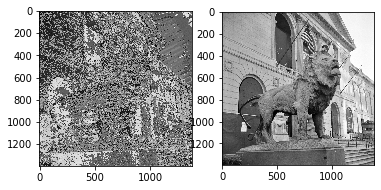

In [76]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(source_copy_pair1, cmap = 'gray')
ax[1].imshow(img2, cmap = 'gray')

In [54]:
# check this patch using photoviewer to better see the results
cv2.imwrite('data/pair1/patch.jpeg',source_copy_pair1)

True

# Pair 2

In [11]:
img_path3='data//pair2//left.png'
img_path4='data//pair2//right.png'
img3=cv2.imread(img_path3,0)
img4=cv2.imread(img_path4,0)
img3 = cv2.resize(img3,(300,300))
img4 = cv2.resize(img4,(300,300))
F2,pts =calculate_and_return_fundamental_matrix(img3,img4)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:45<00:00, 66.21it/s]


In [12]:
F12 = calculate_Fundamental_using_opencv(img3,img4)

In [13]:
F2

matrix([[-7.60054502e-06, -1.37665646e-05, -1.53098869e-03],
        [-3.60199355e-05, -7.79961897e-05, -5.71284857e-03],
        [-2.16680994e-07, -8.26854703e-03,  1.00000000e+00]])

In [14]:
F12

array([[ 5.29414387e-05,  1.92767740e-05, -1.06565774e-02],
       [-1.13929996e-05, -1.15809055e-05,  3.07185124e-03],
       [-5.65175997e-03, -7.43877757e-04,  1.00000000e+00]])

In [15]:
source_copy_pair2_ = get_patched_image(img3,img4,F2)

100%|███████████████████████████████████████████████████████████████████████████| 90000/90000 [01:58<00:00, 759.12it/s]


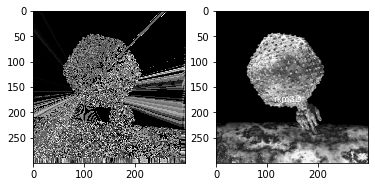

In [16]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(source_copy_pair2_, cmap = 'gray')
ax[1].imshow(img4, cmap = 'gray')

In [17]:
# check this patch using photoviewer to better see the results
cv2.imwrite('data/pair2/patch.jpeg',source_copy_pair2_)

True

# Pair 3

In [18]:
img_path5='data//pair3//left.jpg'
img_path6='data//pair3//right.jpg'
img5=cv2.imread(img_path5,0)
img6=cv2.imread(img_path6,0)
img5 = cv2.resize(img5,(300,300))
img6 = cv2.resize(img6,(300,300))
F3,pts =calculate_and_return_fundamental_matrix(img5,img6)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:46<00:00, 64.59it/s]


In [19]:
F13 = calculate_Fundamental_using_opencv(img5,img6)

In [20]:
F3

matrix([[-1.57322649e-04,  3.68940393e-05, -6.67091543e-03],
        [ 2.18520564e-04, -1.04966225e-04, -1.77842315e-02],
        [-3.83568655e-03,  3.20848302e-03,  1.00000000e+00]])

In [21]:
F13

array([[ 1.69409148e-03, -9.92236607e-04, -6.50993424e-02],
       [-1.15379239e-03,  3.93502195e-04,  4.93148147e-02],
       [-4.99923835e-02,  8.15135254e-02,  1.00000000e+00]])

In [23]:
source_copy_pair2 = get_patched_image(img5,img6,F3)

100%|███████████████████████████████████████████████████████████████████████████| 90000/90000 [03:48<00:00, 393.10it/s]


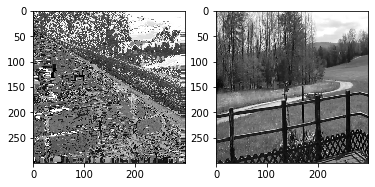

In [24]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(source_copy_pair2, cmap = 'gray')
ax[1].imshow(img6, cmap = 'gray')

In [25]:
# check this patch using photoviewer to better see the results
cv2.imwrite('data/pair3/patch.jpeg',source_copy_pair2)

True

# Pair 4

In [26]:
img_path7='data//pair4//left.jpg'
img_path8='data//pair4//right.jpg'
img7=cv2.imread(img_path7,0)
img8=cv2.imread(img_path8,0)
img7 = cv2.resize(img7,(300,300))
img8 = cv2.resize(img8,(300,300))
F4,pts =calculate_and_return_fundamental_matrix(img7,img8)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:44<00:00, 67.10it/s]


In [27]:
F14 = calculate_Fundamental_using_opencv(img7,img8)

In [28]:
F4

matrix([[ 8.77623077e-06, -1.40410003e-05,  3.59420829e-04],
        [-4.68275192e-05,  8.26068483e-05,  5.73276002e-05],
        [ 3.67130618e-03, -2.56647177e-03,  1.00000000e+00]])

In [29]:
F14

array([[-4.94121691e-07,  1.55603770e-06, -3.34122361e-04],
       [-1.92055974e-06,  1.65445889e-05, -3.83074538e-03],
       [ 5.51026751e-04, -4.33608098e-03,  1.00000000e+00]])

In [30]:
source_copy_pair4 = get_patched_image(img7,img8,F14)

100%|██████████████████████████████████████████████████████████████████████████| 90000/90000 [00:40<00:00, 2219.57it/s]


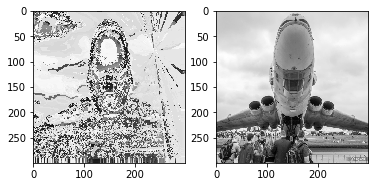

In [31]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(source_copy_pair4, cmap = 'gray')
ax[1].imshow(img8, cmap = 'gray')

In [32]:
# check this patch using photoviewer to better see the results
cv2.imwrite('data/pair4/patch.jpeg',source_copy_pair4)

True

# Pair 5

In [33]:
img_path9='data//pair5//left.jpg'
img_path10='data//pair5//right.jpg'
img9=cv2.imread(img_path9,0)
img10=cv2.imread(img_path10,0)
img9 = cv2.resize(img9,(300,300))
img10 = cv2.resize(img10,(300,300))
F5,pts =calculate_and_return_fundamental_matrix(img9,img10)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:47<00:00, 63.28it/s]


In [34]:
F15 = calculate_Fundamental_using_opencv(img9,img10)

In [35]:
F5

matrix([[-1.25023912e-06, -2.52279866e-05, -3.23506274e-03],
        [-6.83342455e-05,  9.47111040e-05, -1.28422746e-02],
        [-2.12757146e-03,  1.55286723e-02,  1.00000000e+00]])

In [36]:
F15

array([[ 8.37786740e-06,  2.79207288e-05, -5.91113639e-03],
       [-4.55235488e-06,  1.52806190e-05, -1.40897623e-03],
       [-3.78341453e-04, -6.09172544e-03,  1.00000000e+00]])

In [37]:
source_copy_pair5 = get_patched_image(img9,img10,F15)

100%|███████████████████████████████████████████████████████████████████████████| 90000/90000 [02:44<00:00, 546.25it/s]


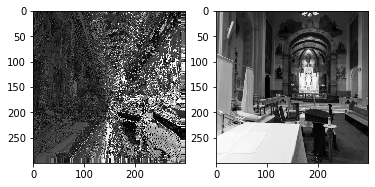

In [38]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(source_copy_pair5, cmap = 'gray')
ax[1].imshow(img10, cmap = 'gray')

In [39]:
# check this patch using photoviewer to better see the results
cv2.imwrite('data/pair5/patch.jpeg',source_copy_pair5)

True